## TO-DO/BUGS/Considerations

### BUGS

- When introducing the ECG as feature, the prediction gives nan values. Need to try to implement a single feature LSTM autoencoder on the ECG and see if the behaviour is different

- Pad sequences with the mean of the feature may force the autoencoder to learn the mean instead the original ditrivution. This problem occurs with HR,RR and DBP. Should I try to set the TIME_STEP to minimum lemght of features?

### TO-DO

- Threshold for anomaly = mean of the reconstruction error for healthy patients (resubstitution error). Above this threshold we can detyect an anomaly. Resubstitution error for every feature: eval_error must return a dictionary of means.

- Covariance matrix

### Considerations

- L'errore di ricostruzione è minore usando la normalizzazione minmax, probabilmente perchè i dati non hanno una distribuzione gaussiana
- Resubstitution error (reconstruction error on training data) is 3 times less than that obtained on the ills patients data with the layers 64,32,16,32,64

## Environment setup

In [1]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer



2023-03-23 16:19:09.492817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data load

### API data load

In [2]:

def load_healthy_API(type='a',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] < 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



In [3]:

def load_ills_API(type='a',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] > 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



### Disk data load

In [4]:
def load_from_disk(path):
    
    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
    filepath = os.path.join(path,'numeric_data.vitaldb')
    ecgpath = os.path.join(path,'ecg_data.vitaldb')
    #ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'

    with open(ecgpath, 'rb') as f:
        (ecg) = pickle.load(f)
    with open(filepath, 'rb') as f:
        (dbp,sbp,bt,hr,rr) = pickle.load(f)
    
    return ecg,dbp,sbp,bt,hr,rr

In [5]:
def save_to_disk(path,ecg,dbp,sbp,bt,hr,rr):
# save the data into a file since loading all the 2k caseids requires at least 1h

    with open(os.path.join(path,'numeric_data.vitaldb'), 'wb') as f:
        pickle.dump((dbp,sbp,bt,hr,rr), f)

    with open(os.path.join(path,'ecg_data.vitaldb'), 'wb') as f:
        pickle.dump(ecg, f)



## save the data into a file since loading all the 2k caseids requires at least 1h
#filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/data.vitaldb'
#ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
#ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'


### Visualize

In [6]:
def plot_data(ecg,dbp,sbp,bt,hr,rr,val = None):
    
    if(val == None or not isinstance(val,int)):
        val = np.argmin(np.array([
                         min([len(el) for el in ecg]),
                         min([len(el) for el in dbp]),
                         min([len(el) for el in sbp]),
                         min([len(el) for el in  bt]),
                         min([len(el) for el in  hr]),
                         min([len(el) for el in  rr])]))
        print(val)
    
    plt.figure(figsize=(20,20))
    plt.subplot(611)
    plt.title("ECG")
    for el in ecg:
        plt.plot(el)
    plt.subplots_adjust(hspace=1.)
    plt.subplot(612)
    plt.title("DBP")
    for el in dbp:
        plt.plot(el, color='b')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(613)
    plt.title("SBP")
    for el in sbp:
        plt.plot(el, color='r')

    plt.subplot(614)
    plt.title("Body temperature")
    for el in bt:
        plt.plot(el, color='orange')

    plt.subplot(615)
    plt.title("Heart rate")
    for el in hr:
        plt.plot(el, color='r')

    plt.subplot(616)
    plt.title("Respiratory rate")
    for el in rr:
        plt.plot(el, color='g')
    plt.show()

## Preprocessing

In [7]:
def clean_data(ecg,dbp,sbp,bt,hr,rr):
# remove empty or with negative mean time series 

    try:
        for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0 or (np.mean(el) <= 0)])): 
            if(len(ecg[i])==0 or (np.mean(ecg[i]) <= 0)):
                ecg.pop(i)
    except:
        pass

    try:
        for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(dbp[i])==0 or (np.mean(dbp[i]) <= 0)):
                dbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(sbp[i])==0 or (np.mean(sbp[i]) <= 0)):
                sbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(bt) - len([el for el in bt if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(bt[i])==0 or (np.mean(bt[i]) <= 0)):
                bt.pop(i)
    except:
        pass

    try:
        for i in range(0,len(hr) - len([el for el in hr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(hr[i])==0 or (np.mean(hr[i]) <= 0)):
                hr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(rr) - len([el for el in rr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(rr[i])==0 or (np.mean(rr[i]) <= 0)):
                rr.pop(i)
    except:
        pass

    return ecg,dbp,sbp,bt,hr,rr




def mean_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})
    print({'dbp':len(dbp),'sbp':len(sbp),'hr':len(hr),'bt':len(bt),'rr':len(rr)})


    ecg_mean,ecg_std = np.mean(flat_list_ecg),np.std(flat_list_ecg)
    dbp_mean,dbp_std = np.mean(flat_list_dbp),np.std(flat_list_dbp)
    sbp_mean,sbp_std = np.mean(flat_list_sbp),np.std(flat_list_sbp)
    bt_mean,bt_std = np.mean(flat_list_bt),np.std(flat_list_bt)
    hr_mean,hr_std = np.mean(flat_list_hr),np.std(flat_list_hr)
    rr_mean,rr_std = np.mean(flat_list_rr),np.std(flat_list_rr)

    print('\nMean values for features:')
    print({'ecg':ecg_mean,'dbp':dbp_mean,'sbp':sbp_mean,'hr':hr_mean,'bt':bt_mean,'rr':rr_mean})
    print('\nStd values for features:')
    print({'ecg':ecg_std,'dbp':dbp_std,'sbp':sbp_std,'hr':hr_std,'bt':bt_std,'rr':rr_std})
    print('\n')

    # Consider runtime warnings such as Divide by zero as Exceptions to throw
    old_settings = np.seterr(divide='raise')
    idx_remove = {}
    idx_remove['ecg'] = []
    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []
    

    for i in range(0,len(ecg)): 
        try:
            ecg[i][np.argwhere(ecg[i] < 0)] = np.mean(ecg[i])
            ecg[i] = (ecg[i] - ecg_mean)/(ecg_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['ecg'].append(i)
                

    for i in range(0,len(dbp)): 
        try:
            dbp[i][np.argwhere(dbp[i] <= 30)] = np.mean(dbp[i])
            dbp[i] = (dbp[i] - dbp_mean)/(dbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)



    for i in range(0,len(sbp)): 
        try:
            sbp[i][np.argwhere(sbp[i] <= 70 )] = np.mean(sbp[i])
            sbp[i] = (sbp[i] - sbp_mean)/(sbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)
        


    for i in range(0,len(bt)): 
        try:
            bt[i][np.argwhere(bt[i] <= 33)] = np.mean(bt[i])
            bt[i] = (bt[i] - bt_mean)/(bt_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            hr[i][np.argwhere(hr[i] <= 35)] = np.mean(hr[i])
            hr[i] = (hr[i] - hr_mean)/(hr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    for i in range(0,len(rr)): 
        try:
            rr[i][np.argwhere(rr[i] <= 8)] = np.mean(rr[i])
            rr[i] = (rr[i] - rr_mean)/(rr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    # Back to default settings for errors
    np.seterr(**old_settings)

    return ecg,dbp,sbp,bt,hr,rr,idx_remove





def minmax_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    ecg_min,ecg_max = np.min(flat_list_ecg),np.max(flat_list_ecg)
    dbp_min,dbp_max = np.min(flat_list_dbp),np.max(flat_list_dbp)
    sbp_min,sbp_max = np.min(flat_list_sbp),np.max(flat_list_sbp)
    bt_min,bt_max = np.min(flat_list_bt),np.max(flat_list_bt)
    hr_min,hr_max = np.min(flat_list_hr),np.max(flat_list_hr)
    rr_min,rr_max = np.min(flat_list_rr),np.max(flat_list_rr)
    
    old_settings = np.seterr(divide='raise')
    idx_remove = {}
    idx_remove['ecg'] = []
    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []

    for i in range(0,len(ecg)): 
        try:
            ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i])
            ecg[i] = (ecg[i] - ecg_min)/(ecg_max - ecg_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['ecg'].append(i)


    for i in range(0,len(dbp)): 
        try:
            dbp[i][np.argwhere(dbp[i]<=30)] = np.mean(dbp[i])
            dbp[i] = (dbp[i] - dbp_min)/(dbp_max - dbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)


    for i in range(0,len(sbp)): 
        try:
            sbp[i][np.argwhere(sbp[i] <= 70)] = np.mean(sbp[i])
            sbp[i] = (sbp[i] - sbp_min)/(sbp_max - sbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)


    for i in range(0,len(bt)): 
        try:
            bt[i][np.argwhere(bt[i]<=33)] = np.mean(bt[i])
            bt[i] = (bt[i] - bt_min)/(bt_max - bt_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            #hr[i][np.argwhere(hr[i]<=35)] = np.mean(hr[i])
            hr[i] = (hr[i] - hr_min)/(hr_max - hr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)


    for i in range(0,len(rr)): 
        try:
            #rr[i][np.argwhere(rr[i]<=8)] = np.mean(rr[i])
            rr[i] = (rr[i] - rr_min)/(rr_max - rr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['rr'].append(i)


    # Back to default settings for errors
    np.seterr(**old_settings)

    return ecg,dbp,sbp,bt,hr,rr,idx_remove



def get_preprocessed_data(path, norm_func = None):

    ecg,dbp,sbp,bt,hr,rr = load_from_disk(path=path)
    ecg,dbp,sbp,bt,hr,rr = clean_data(ecg,dbp,sbp,bt,hr,rr)

    if(norm_func is not None):
        ecg,dbp,sbp,bt,hr,rr,idx_remove = norm_func(ecg,dbp,sbp,bt,hr,rr)
        
    idx_remove = []
    return ecg,dbp,sbp,bt,hr,rr,idx_remove


In [8]:
path = '/Users/Roberto/projects/AnomalyDetection/data/processed'
norm = 'minmax'
func_norm = norm + '_norm'
normalize = globals()[func_norm] # normalize is called later for test data normalization

ecg,dbp,sbp,bt,hr,rr,idx_remove = get_preprocessed_data(path = path,norm_func = normalize)

# Autoencoder

## LSTM Autoencoder


### Multivariate

In [43]:
def preprocess(ecg,dbp,sbp,bt,hr,rr, TIME_STEP = 5000, n_instances = None):

    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'ecg': len(flat_list_ecg),'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    X_ecg = []
    X_dbp = []
    X_sbp = []
    X_bt = []
    X_hr = []
    X_rr = []

    for seq in range(0,len(flat_list_ecg), TIME_STEP):
        X_ecg.append(flat_list_ecg[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_dbp), TIME_STEP):
        X_dbp.append(flat_list_dbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_sbp), TIME_STEP):
        X_sbp.append(flat_list_sbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_bt), TIME_STEP):
        X_bt.append(flat_list_bt[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_hr), TIME_STEP):
        X_hr.append(flat_list_hr[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_rr), TIME_STEP):
        X_rr.append(flat_list_rr[seq:seq+TIME_STEP])

    X_ecg = np.asarray(X_ecg,dtype=object)
    X_dbp = np.asarray(X_dbp,dtype=object)
    X_sbp = np.asarray(X_sbp,dtype=object)
    X_bt = np.asarray(X_bt,dtype=object)
    X_hr = np.asarray(X_hr,dtype=object)
    X_rr = np.asarray(X_rr,dtype=object)


    X_ecg = pad_sequences(X_ecg, TIME_STEP,padding='post',value = np.mean(flat_list_ecg),dtype='float64')
    X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_dbp),dtype='float64')
    X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_sbp),dtype='float64')
    X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_bt),dtype='float64')
    X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hr),dtype='float64')
    X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_rr),dtype='float64')


    X_ecg = np.asarray(np.expand_dims(X_ecg,axis=2))
    X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
    X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
    X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
    X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
    X_rr = np.asarray(np.expand_dims(X_rr,axis=2))


    min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])
    
    X_ecg = X_ecg[:min_len,:]
    X_dbp = X_dbp[:min_len,:]
    X_sbp = X_sbp[:min_len,:]
    X_bt = X_bt[:min_len,:]
    X_hr = X_hr[:min_len,:]
    X_rr = X_rr[:min_len,:]

    Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
    
    if(isinstance(n_instances,int) and n_instances > 0):
        X = Y[:n_instances] # Select the first n instances
    else:
        X = Y

    return X



def eval_error(X_test,res,full = False):

    n = min(X_test.shape[0],res.shape[0])
    overall_mean = 0

    dict_means = {}
    dict_means['sbp'] = 0
    dict_means['dbp'] = 0
    dict_means['bt'] = 0
    dict_means['rr'] = 0
    dict_means['hr'] = 0

    dic = {}
    dic[0] = 0
    dic[1] = 0
    dic[2] = 0
    dic[3] = 0
    dic[4] = 0
    
    for p in range(0,n):
        # Print the reconstruction error for all the features of a given test instance
        #print('=======================================')
        print('\tTest instance ' + str(p))
        #print('======================================='+'\n')
        tot = 0
        for i in range(0,5):
            re = np.round(abs(np.linalg.norm(res[p,:,i]) - np.linalg.norm(X_test[p,:,i],2)),3)
            tot = tot + re

            if(full == True):
                print('Reconstrucion error on feature ' + str(i) + ': ' + \
                      str(re)+'\n')
            dic[i] = dic[i] + re

        mean = np.round(tot/5,3)
        overall_mean = overall_mean + mean
        print('Mean reconstruction error: ' + str(mean))
        print('\n')

    dict_means['sbp'] = dic[0]/n
    dict_means['dbp'] = dic[1]/n
    dict_means['bt'] = dic[2]/n
    dict_means['rr'] = dic[3]/n
    dict_means['hr'] = dic[4]/n

    del dic
        
    overall_mean = overall_mean/n
    return overall_mean,dict_means

In [18]:
X_train = preprocess(ecg,dbp,sbp,bt,hr,rr)
batch_size, seq_len, n_features = X_train.shape

model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, n_features),return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5000, 64)          17920     
                                                                 
 dropout_13 (Dropout)        (None, 5000, 64)          0         
                                                                 
 lstm_15 (LSTM)              (None, 5000, 32)          12416     
                                                                 
 dropout_14 (Dropout)        (None, 5000, 32)          0         
                                                                 
 lstm_16 (LSTM)              (None, 5000, 64)          24832     
                                                                 
 dropout_15 (Dropout)        (None, 5000, 64)          0         
                                                                 
 time_distributed_4 (TimeDis  (None, 5000, 5)         

In [20]:
history = model.fit(X_train, X_train, batch_size=128 ,validation_split=0.2, epochs=3,shuffle=False,verbose=1)

Epoch 1/3
20/20 [==============================] - 336s 16s/step - loss: 0.1244 - val_loss: 0.0396
Epoch 2/3
20/20 [==============================] - 312s 16s/step - loss: 0.0927 - val_loss: 0.0312
Epoch 3/3
20/20 [==============================] - 315s 16s/step - loss: 0.0820 - val_loss: 0.0266


#### Predict

In [29]:
n_cases = 10

nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr = load_ills_API()
nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr = clean_data(nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr)
nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr,_ = normalize(nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr)

#hecg,hdbp,hsbp,hbt,hhr,hrr = load_healthy_API(n_cases=n_cases)
hecg,hdbp,hsbp,hbt,hhr,hrr = ecg,dbp,sbp,bt,hr,rr
#hecg,hdbp,hsbp,hbt,hhr,hrr = clean_data(hecg,hdbp,hsbp,hbt,hhr,hrr)
#hecg,hdbp,hsbp,hbt,hhr,hrr,_ = normalize(hecg,hdbp,hsbp,hbt,hhr,hrr) # normalize the test instance with the same approach of train ones

In [23]:
X_test_nh = preprocess(nhecg,nhdbp,nhsbp,nhbt,nhhr,nhrr)
X_test_h  = preprocess(hecg,hdbp,hsbp,hbt,hhr,hrr)

res_nh = model.predict(X_test_nh)
res_h = model.predict(X_test_h)


print(X_test_h.shape,X_test_nh.shape)

#n_feature = 1
#abs(np.linalg.norm(res[...,n_feature]) - np.linalg.norm(X_test[...,n_feature],2))

98/98 [==============================] - 186s 2s/step
(3125, 5000, 5) (10, 5000, 5)


In [44]:
print('\nHEALTHY PATIENTS\n')
resub_err,d = eval_error(X_test_h,res_h,True)
print('\nILL PATIENTS\n')
nh_err,dd = eval_error(X_test_nh,res_nh,True)


HEALTHY PATIENTS

	Test instance 0
Reconstrucion error on feature 0: 0.374

Reconstrucion error on feature 1: 2.126

Reconstrucion error on feature 2: 2.06

Reconstrucion error on feature 3: 0.699

Reconstrucion error on feature 4: 0.744

Mean reconstruction error: 1.201


	Test instance 1
Reconstrucion error on feature 0: 0.328

Reconstrucion error on feature 1: 0.971

Reconstrucion error on feature 2: 1.632

Reconstrucion error on feature 3: 1.051

Reconstrucion error on feature 4: 0.717

Mean reconstruction error: 0.94


	Test instance 2
Reconstrucion error on feature 0: 0.837

Reconstrucion error on feature 1: 0.254

Reconstrucion error on feature 2: 2.552

Reconstrucion error on feature 3: 0.535

Reconstrucion error on feature 4: 0.476

Mean reconstruction error: 0.931


	Test instance 3
Reconstrucion error on feature 0: 0.386

Reconstrucion error on feature 1: 1.103

Reconstrucion error on feature 2: 2.947

Reconstrucion error on feature 3: 1.029

Reconstrucion error on feature 

In [48]:
print(d)
print(dd)

{'sbp': 1.0250540799999983, 'dbp': 1.4294867200000014, 'bt': 2.616985600000003, 'rr': 1.0409161600000012, 'hr': 1.4026003200000001}
{'sbp': 1.3973725490196076, 'dbp': 1.8769411764705883, 'bt': 5.846509803921566, 'rr': 13.360627450980392, 'hr': 1.1209019607843136}


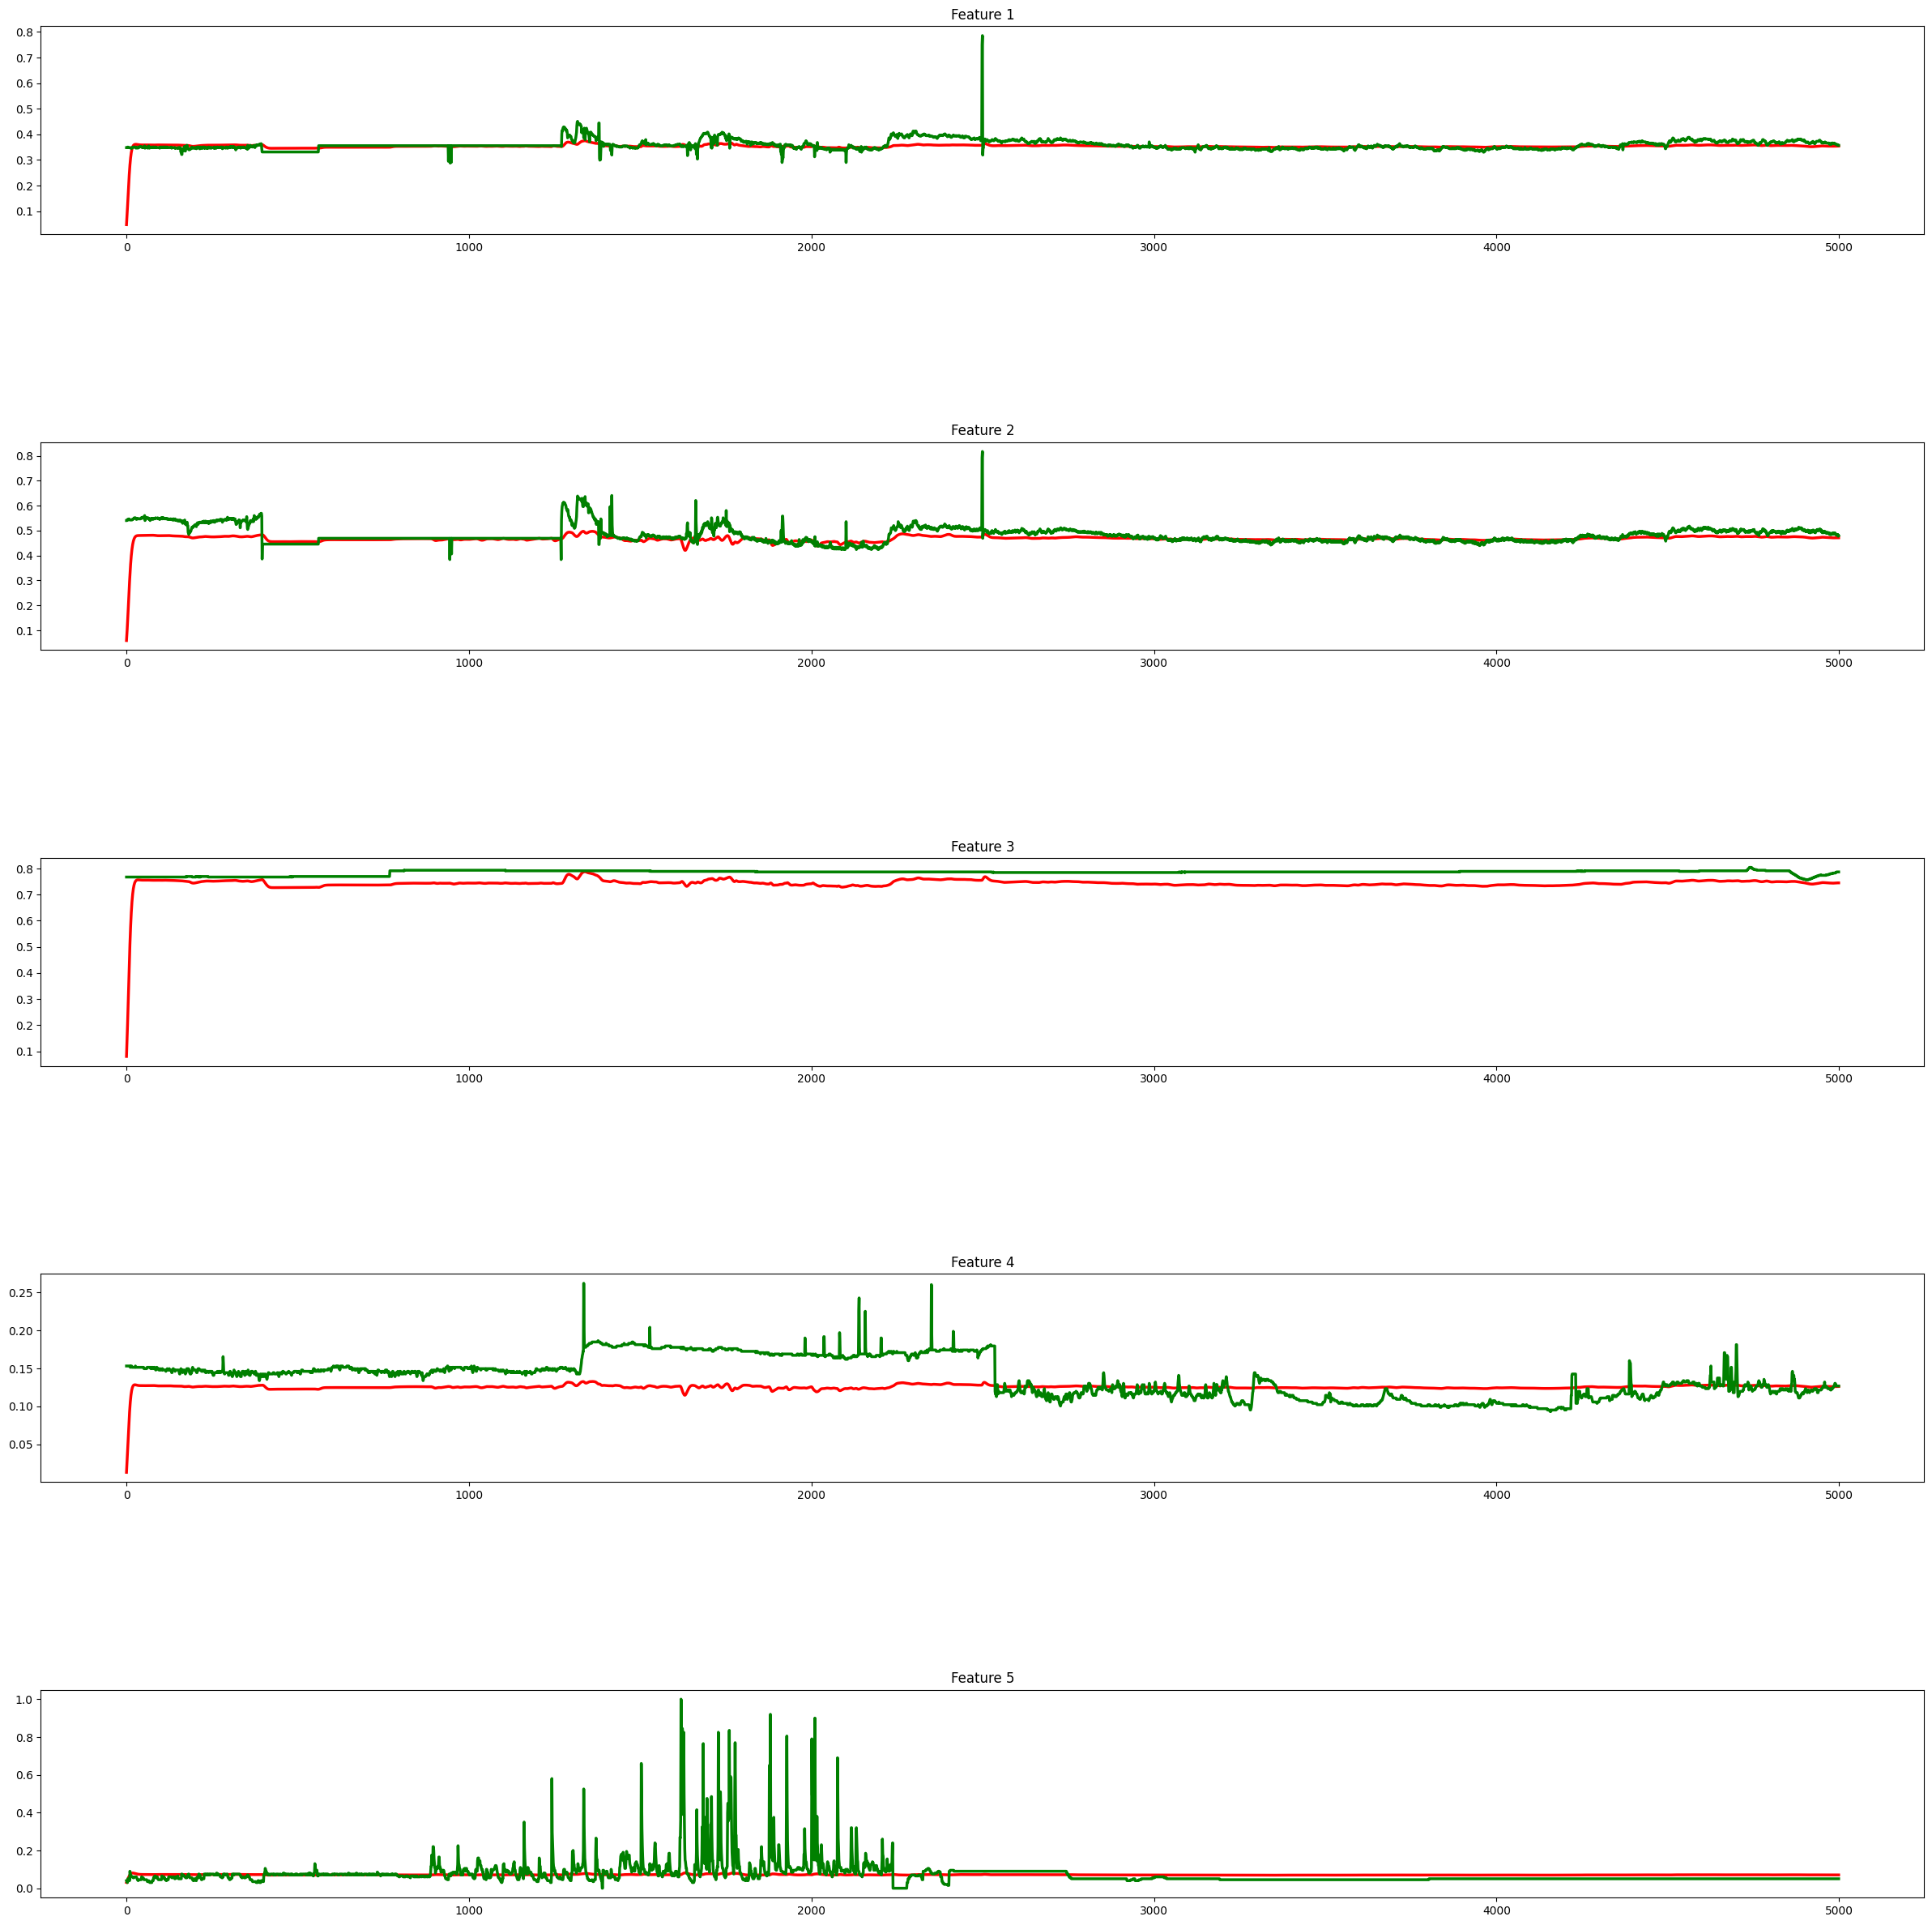

In [26]:

p = 3 # test instance

plt.figure(figsize=(30,30))
for i in range(0,5):
    s = '51'+str(i+1)
    plt.subplot(int(s))
    plt.subplots_adjust(hspace=1.)
    plt.title('Feature ' + str(i+1))
    plt.plot(res_h[p,:,i],'-r',X_test_h[p,:,i],'-g', linewidth=2.5)

plt.show()



# Plot all the feature data

#plt.figure(figsize=(20,10))
#plt.subplot(211)
#plt.plot(res[...,1])
#plt.subplot(212)
#plt.plot(X_test[...,1])
#plt.show()

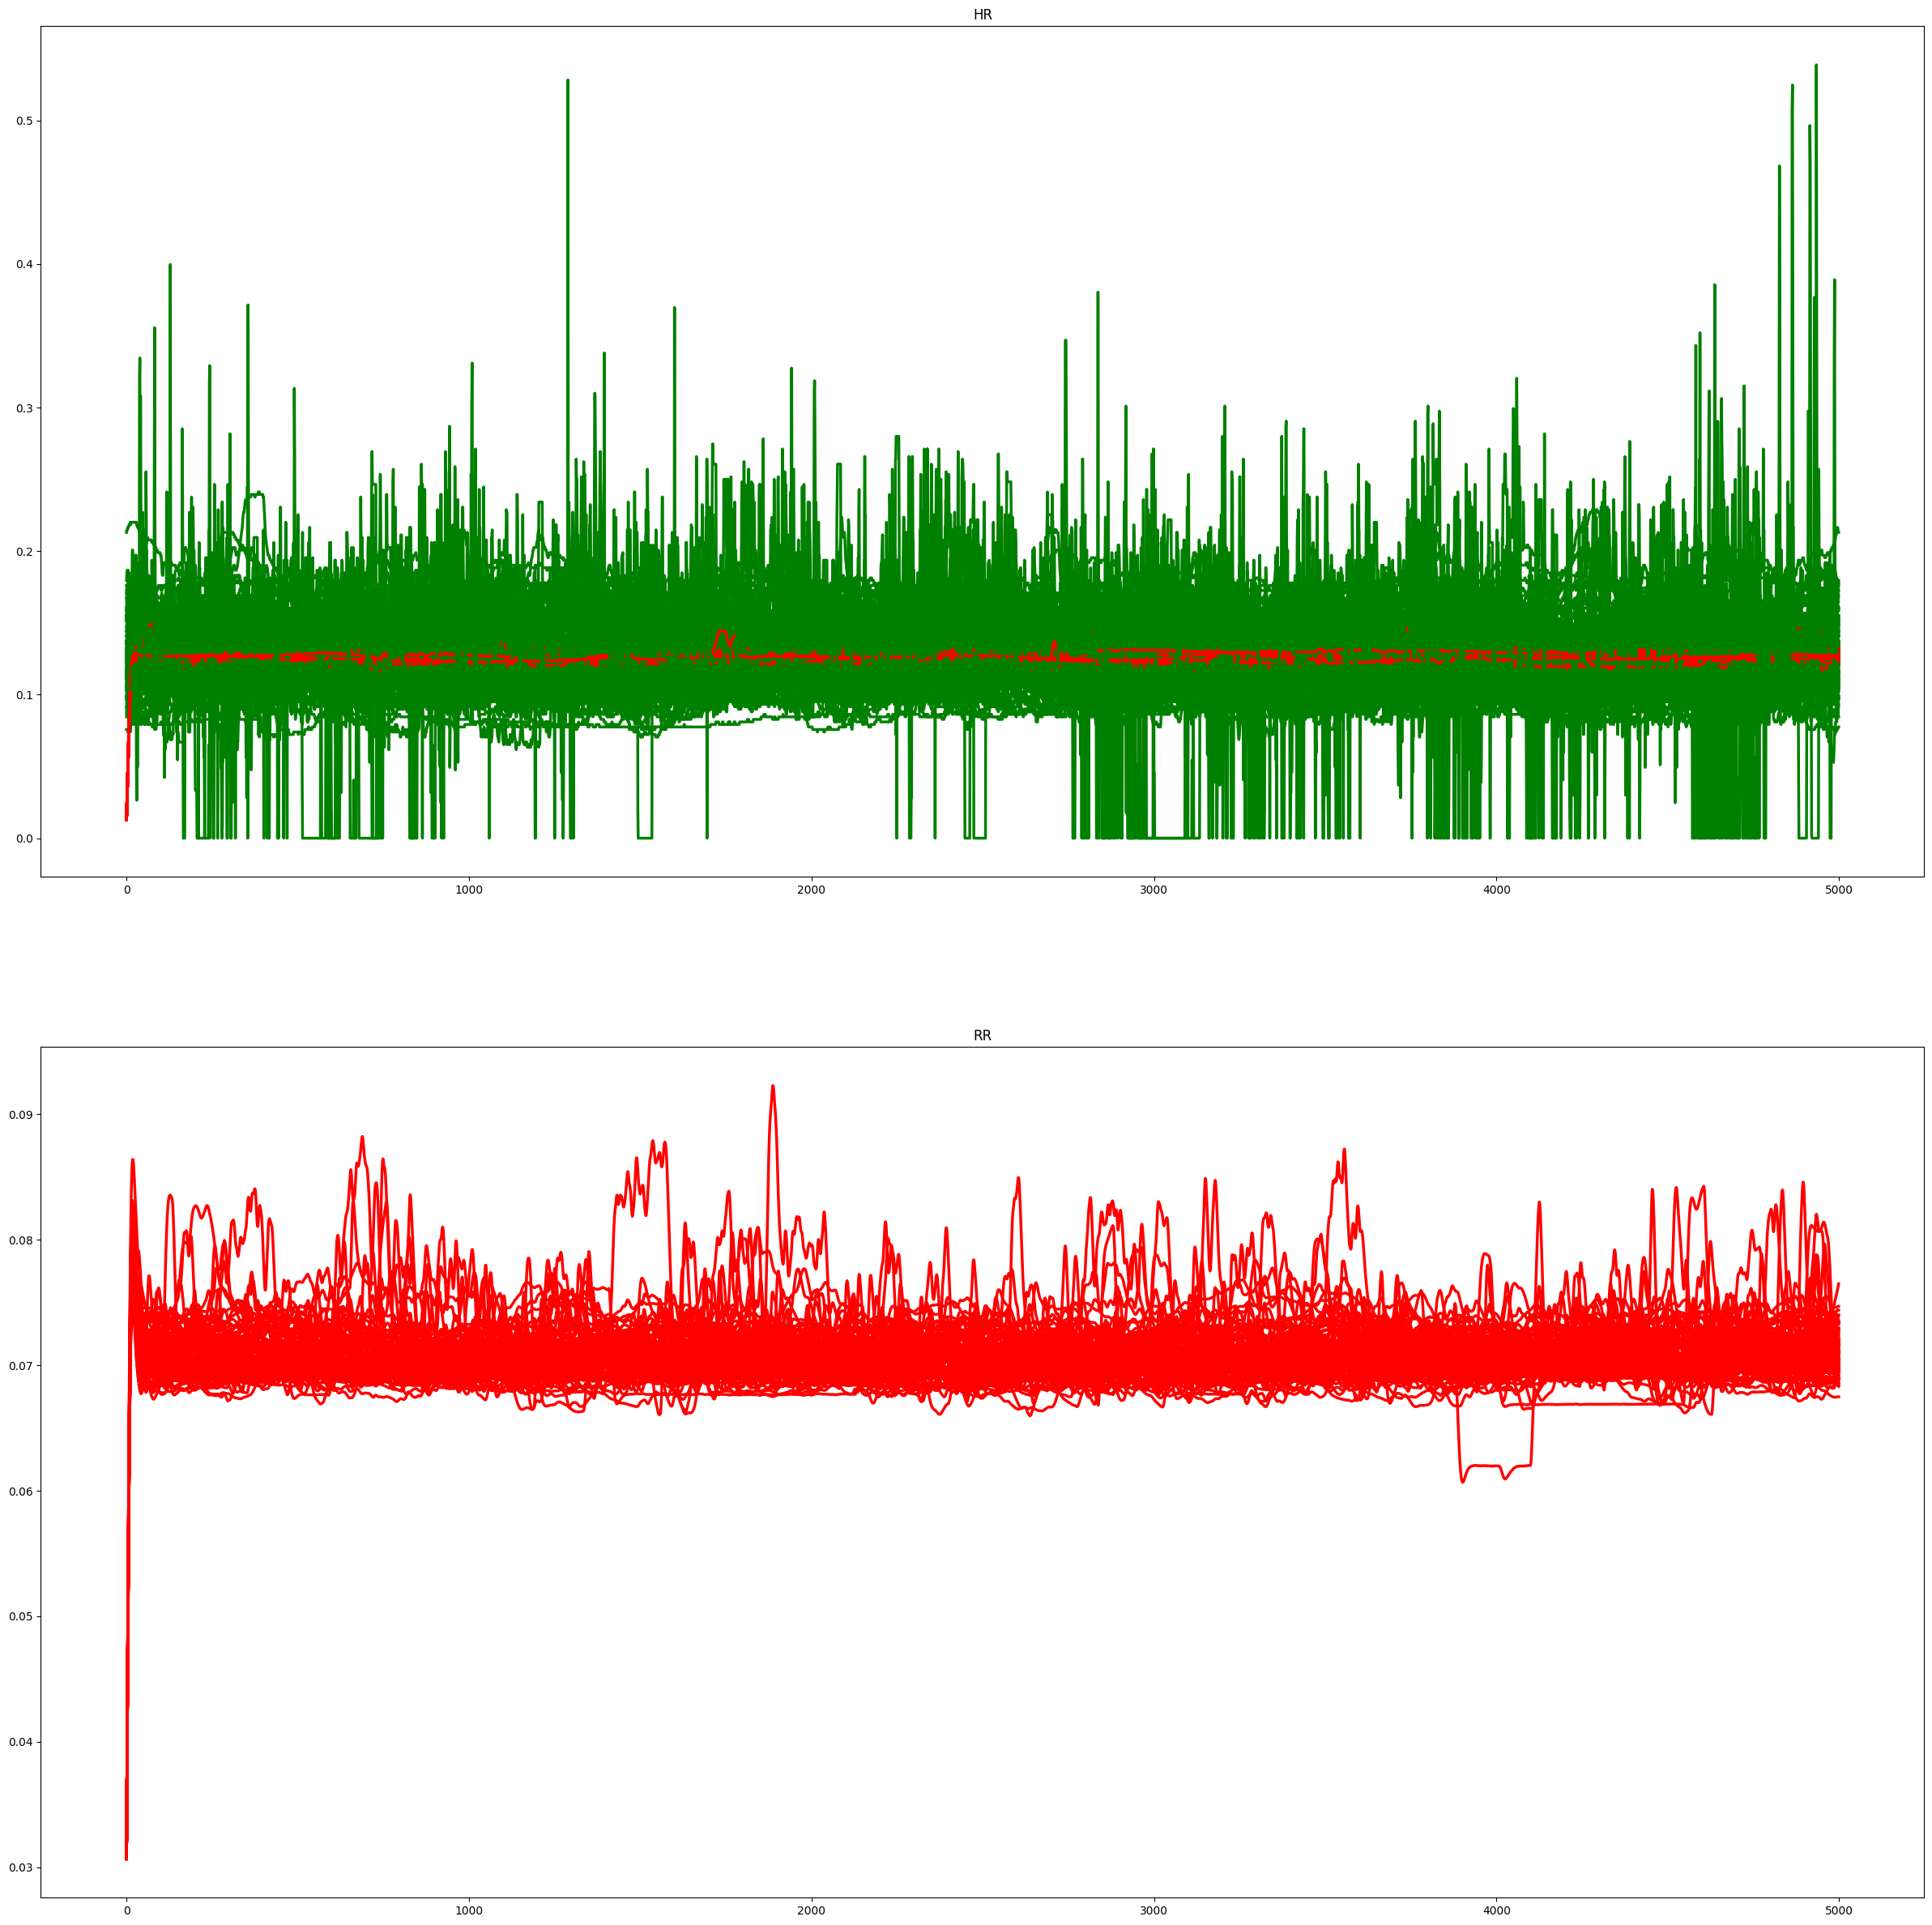

In [40]:
plt.figure(figsize=(30,30))
plt.subplot(211)
n=100
for i in range(0,n):
    plt.title('HR')
    plt.plot(res_h[i,:,3],'-r',X_test_h[i,:,3],'-g',linewidth=2.5)

plt.subplot(212)
for i in range(0,n):
    plt.title('RR')
    plt.plot(res_h[i,:,4],'-r',linewidth=2.5)
    #plt.plot(X_test_h[i,:,4],'-g', alpha=0.5 ,linewidth=2.5)
    

plt.show()


In [28]:
np.min([np.mean([len(el) for el in dbp]),np.mean([len(el) for el in sbp]),np.mean([len(el) for el in bt]),np.mean([len(el) for el in rr]),np.mean([len(el) for el in hr])])

5432.817107093185